# 0) 1-D Time-series forecasting basic toolkit  

In [92]:
# %load time_series_1.py
#!/usr/bin/env python2
"""
1-D Time-series prediction toolkit

@author: yuki
"""

'''
here are the various implemented algorithms, including their hyperparamter optimizations

''' 
from scipy.optimize import minimize
def AR_model(X,p,method=0,alpha=0.):
    """just fits the Least Squares AR model with alpha as regularization"""
    # X is datalength x dim
    # construct embedding matrix by shifting
    if method==0: # embedding matrix
        M = np.zeros(dtype='float',shape=(X.shape[0]-p, p, X.shape[1]))
        A = np.zeros(dtype='float',shape=(p, X.shape[1]))
        for dim in range(X.shape[1]):
            M[:,:,dim] = np.array([(X[k:k+p,dim])[::-1] for k in range(X.shape[0] - p)])
            A[:,dim] =  np.linalg.solve(np.dot(M[:,:,dim].T, M[:,:,dim])+np.eye(p)*alpha,
                                        np.dot(M[:,:,dim].T, X[p:,dim]))
    else:
        return 0 #implement at some point
    return A
    
def AR_rmse(theta,args):
    """returns RMSE of AR 1-step predictions for the validationset"""
    [alpha] = theta
    [p,X,n_valid,n_testper] = args
    for k in range(X.shape[0]-n_valid-n_testper,X.shape[0]-n_testper):
        X_train = X[0:k]
        X_valid = X[k:k+n_testper]
        pred = []
        X2 = X_train.copy()
        for j in range(n_testper):
            a = AR_model(X2[:,np.newaxis],int(p),alpha=alpha)
            yt = np.sum(a[:,0]* X2[-int(p):][::-1])
            X2 = np.hstack((X2,yt))
            pred.append(yt)
    return np.sqrt(np.sum((np.array(pred)-X_valid)**2)) # works only for n_testper =1

def predict_optimize_ARp(X_, n_predict, n_valid,n_testper,ps=range(1,20)):
    """this code optmizes for alpha for each lag-length p in ps 
        and returns a prediction using the best parameters of the validation set"""
    rmse=[]
    params=[]
    for p in ps:
        res = minimize(AR_rmse, 0.2, args=[p,X_[:-n_predict],n_valid,n_testper], method='Nelder-Mead',tol=1e-3,
                      options={'maxiter':50})
        params.append(res.x) 
        rmse.append(res.fun)
    # now we have best hypterparameter  params[np.argmin(rmse), ps[np.argmin(rmse)
    
    # now train using all data except test
    a = AR_model(X_[:-n_predict-ps[np.argmin(rmse)],np.newaxis],ps[np.argmin(rmse)],alpha=params[np.argmin(rmse)])
    # now we have the optimzed parameters in a
    rslts = [np.sum(a[:,0]* X_[-ps[np.argmin(rmse)]-k:-k][::-1]) for k in range(1,n_predict)][::-1]
    rslts.append(np.sum(a[:,0]* X_[-ps[np.argmin(rmse)]:][::-1]))
    return  a, rslts
#%%
#### LSTM 
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import itertools
 
# convert series to supervised learning, i.e. lagged time-series is input, next value is target
def predict_optimize_LSTM(X_,n_predict, n_valid,n_testper, windows=range(3,4), lstmsizes=range(1,3),
                         trainepochs=35, testepochs=40):
    X_ = X_[:,np.newaxis]
    rmses=[]
    forecasts=[]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    dataset = X_.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    for window,lstmsize in list(itertools.product(windows,lstmsizes)):
        # split into train and test sets
        train, test = dataset[:-n_predict-n_valid-window,:], dataset[-n_predict-n_valid-window:-n_predict-window,:]
        # reshape into X=t and Y=t+1
        look_back = window
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(lstmsize, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        _ = model.fit(trainX, trainY, epochs=trainepochs, batch_size=1, verbose=0)
        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
        rmses.append(np.sqrt(np.sum( (testY[0] - testPredict[:,0])**2)))
    
    # now use best model ###############################
    window, lstmsize  =  list(itertools.product(windows,lstmsizes))[np.argmin(rmses)]
    train, test = dataset[:-n_predict-window,:], dataset[-n_predict-window:,:]
    # reshape into X=t and Y=t+1
    look_back = window
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    testX = np.append(testX, np.array(dataset[-look_back-1:-1]).T,0)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(lstmsize, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    _ = model.fit(trainX, trainY, epochs=testepochs, batch_size=1, verbose=0)
    # make predictions
    testPredict = model.predict(testX)

    testPredict = scaler.inverse_transform(testPredict)
    return model, [window, lstmsize], testPredict
    # shift train predictions for plotting
#%%

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def optimize_predict_rf(X_,n_predict,look_back):
    """optmizes and predicts via random forest regression"""
    parameters = {'n_estimators': [10,50,100,200], 'min_samples_leaf':[1,5,10], 'max_depth':[1,5,10,100]}
    model = RandomForestRegressor(random_state=1)
    clf = GridSearchCV(model, parameters,n_jobs=8)
    X_ = X_[:,np.newaxis]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    window = look_back
    train, test = X_[:-n_predict-window,:], X_[-n_predict-window:,:]
    X_train, y_train = create_dataset(train,window)
    
    clf.fit(X_train, y_train)
    X_test, y_test = create_dataset(test,window)
    X_test = np.append(X_test, np.array(X_[-window-1:-1]).T,0)

    y_pred = clf.best_estimator_.predict(X_test)
    return clf.best_estimator_, y_pred

from sklearn import linear_model
def optimize_predict_ridge(X_,n_predict,look_back):
    """optmizes and predicts via ridge regression"""
    parameters = {'alpha': [0.01,0.1,0.5,1,10,50,100], 'normalize':[True,False]}
    model = linear_model.Ridge(fit_intercept=True, normalize=False)
    clf = GridSearchCV(model, parameters,n_jobs=8)
    X_ = X_[:,np.newaxis]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    window = look_back
    train, test = X_[:-n_predict-window,:], X_[-n_predict-window:,:]
    X_train, y_train = create_dataset(train,window)
    
    clf.fit(X_train, y_train)
    X_test, y_test = create_dataset(test,window)
    X_test = np.append(X_test, np.array(X_[-window-1:-1]).T,0)

    y_pred = clf.best_estimator_.predict(X_test)
    return clf.best_estimator_, y_pred

def optimize_predict_lasso(X_,n_predict,look_back):
    """optmizes and predicts via Lasso regression"""
    parameters = {'alpha': [0.01,0.1,0.5,1,10,50,100], 'normalize':[True,False]}
    model = linear_model.Lasso(fit_intercept=True, normalize=False, max_iter=5000)
    clf = GridSearchCV(model, parameters,n_jobs=8) 
    X_ = X_[:,np.newaxis]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    window = look_back
    train, test = X_[:-n_predict-window,:], X_[-n_predict-window:,:]
    X_train, y_train = create_dataset(train,window)
    
    clf.fit(X_train, y_train)
    X_test, y_test = create_dataset(test,window)
    X_test = np.append(X_test, np.array(X_[-window-1:-1]).T,0)

    y_pred = clf.best_estimator_.predict(X_test)
    return clf.best_estimator_, y_pred

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline 

In [3]:
fin = loadmat('finPredProb.mat')['ttr']
co2 = loadmat('co2.mat')['co2']
ssp_train = loadmat('sunspots.mat')['activity'][:1900]
ssp_test = loadmat('sunspots.mat')['activity'][1900:]

mck_train = loadmat('mg.mat')['t_tr']
mck_test = loadmat('mg.mat')['t_te']


print fin.shape, co2.shape, ssp_train.shape, mck_test.shape,mck_train.shape

(14400, 1) (679, 1) (1900, 1) (200, 1) (800, 1)


# 1a) Mackey-Glass data (1-step)

In [121]:
# here: make one-step predictions (that get correct value after each 1-step)
import joblib
n_predict = 200
n_valid = 100
n_testper = 1  
X_in = np.append(mck_train,mck_test)

theta, mck_arp = predict_optimize_ARp(X_in,n_predict, n_valid,n_testper,ps=range(1,200,2))
rf, mck_rf = optimize_predict_rf(X_in, n_predict,look_back=80)
lstm, params, mck_lstm = predict_optimize_LSTM(X_in,n_predict, n_valid,n_testper, 
                                              windows=range(20,30,1), lstmsizes=range(1,4),
                                                trainepochs=30, testepochs=40)
rdg, mck_rdg = optimize_predict_ridge(X_in, n_predict,look_back=80)
las, mck_las = optimize_predict_ridge(X_in, n_predict,look_back=80)


mck_lstm = joblib.load('mck_lstm')


In [131]:
rmses1_mck = np.array([np.sqrt(np.sum((x-mck_test)**2)) for x in [mck_arp,mck_arp,mck_lstm,mck_rdg,mck_las]])
print rmses1_mck/10000
print len(theta)

[ 6.15683302  6.15683302  0.01224371  6.11515383  6.11515383]
3


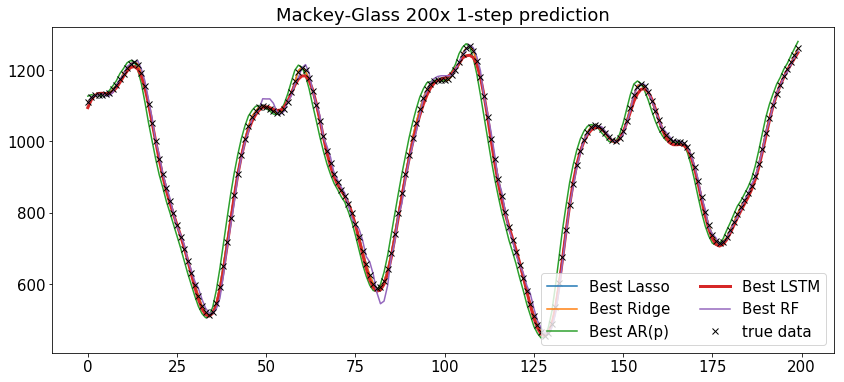

In [128]:
from matplotlib import rcParams

rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(14,6))
plt.plot(mck_las,label='Best Lasso') #[np.argmin(rmses)],label='1-step y_pred')


plt.plot(mck_rdg,label='Best Ridge') #[np.argmin(rmses)],label='1-step y_pred')
plt.plot(mck_arp,label='Best AR(p)')
plt.plot(mck_lstm,label='Best LSTM',lw=3)
plt.plot(mck_rf,label='Best RF')
plt.plot(X_in[-n_predict:],'kx',label='true data')
plt.legend(ncol=2)
plt.title('Mackey-Glass 200x 1-step prediction')
fig.savefig('Mck_1step.pdf',bbox_inches='tight')



# 1b) Mackey-Glass (200-step)

In [93]:
# here: just use train set and instead do a 200-step forecast
n_predict = 2
n_valid = 100
n_testper = 1  
mck_train = loadmat('mg.mat')['t_tr']
X_in = np.append(mck_train[:-1],mck_train[-1])
theta, mck_arp = predict_optimize_ARp(X_in,n_predict, n_valid,n_testper,ps=range(50,250))
rf, mck_rf = optimize_predict_rf(X_in, n_predict,look_back=80)
lstm, params, mck_lstm = predict_optimize_LSTM(X_in,n_predict, n_valid,n_testper, 
                                             windows=range(20,30,1), lstmsizes=range(1,3),
                                               trainepochs=30, testepochs=40)
rdg, mck_rdg = optimize_predict_ridge(X_in, n_predict,look_back=80)
las, mck_las = optimize_predict_lasso(X_in, n_predict,look_back=80)



In [94]:
def create_dataset2(dataset, look_back=3):
    dataX= []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    return np.array(dataX)
# data for lstm
mck_train = loadmat('mg.mat')['t_tr']

window = params[0]
xx = mck_train[-len(theta):].copy().T
scaler = MinMaxScaler(feature_range=(0, 1))
mck_scaled = scaler.fit_transform(mck_train)
x_lstm = mck_scaled[-window:].copy().T

x_rf = mck_train[-80:].copy().T
x_rdg = mck_train[-80:].copy().T
x_las = mck_train[-80:].copy().T


n_predict =200

Preds = np.zeros(shape=(5,n_predict))
for i in range(n_predict):
    Preds[0,i] = np.sum(theta[:,0]* (xx[0,:][::-1]))
    Preds[1,i] = rf.predict(x_rf)
    pre = lstm.predict(np.reshape(x_lstm, (x_lstm.shape[0], 1, x_lstm.shape[1])))
    Preds[2,i] = scaler.inverse_transform(pre)
    Preds[3,i] = rdg.predict(x_rdg)
    Preds[4,i] = las.predict(x_las)

    xx[0,0:-1] = xx[0,1:].copy()
    x_rf[0,0:-1] = x_rf[0,1:].copy()
    x_rdg[0,0:-1] = x_rdg[0,1:].copy()
    x_las[0,0:-1] = x_las[0,1:].copy()


    x_lstm[0,0:-1] = x_lstm[0,1:].copy()
    x_lstm[0,-1] = pre
    xx[0,-1] = Preds[0,i].copy()
    x_rf[0,-1] = Preds[1,i].copy()
    x_rdg[0,-1] = Preds[3,i].copy()
    x_las[0,-1] = Preds[4,i].copy()

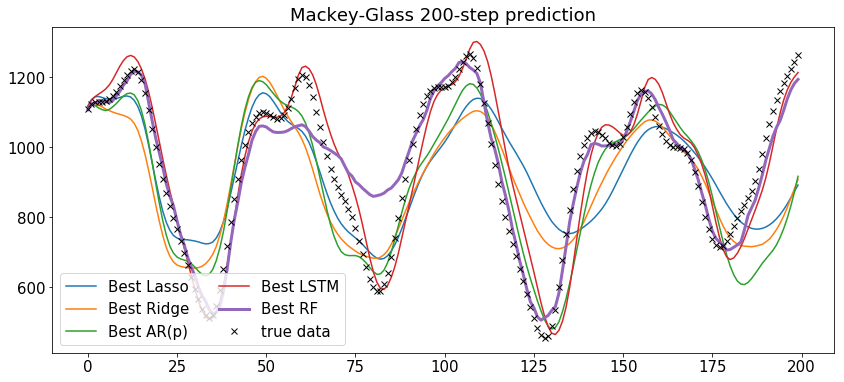

In [113]:
from matplotlib import rcParams

rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(14,6))
plt.plot(Preds[4,:],label='Best Lasso')
plt.plot(Preds[3,:],label='Best Ridge')
plt.plot(Preds[0,:],label='Best AR(p)')
plt.plot(Preds[2,:],label='Best LSTM')


plt.plot(Preds[1,:],label='Best RF',lw=3)


plt.plot(mck_test[:200],'kx',label='true data')
plt.title('Mackey-Glass 200-step prediction')
plt.legend(ncol=2)
fig.savefig('Mck_200.pdf',bbox_inches='tight')


In [108]:
rmses200_mck = np.sqrt(np.sum((Preds-mck_test[:200].T)**2,1))#) for x in [Preds[0,:],Preds[1,:],Preds[2,:],Preds[3,:],Preds[4,:]]]
print np.array(rmses200_mck)/10000

[ 0.192404    0.10136027  0.11994585  0.21346535  0.22597704]


In [120]:
print window, len(theta)

26 172


# 2) CO2 concentration (predicting first differences)

In [217]:
n_predict = 2
n_valid = 100
n_testper = 1  
X_in = co2
print co2.shape
diffco2 = (X_in.T[0][1:] - X_in.T[0][:-1] )
theta, diffco2_arp = predict_optimize_ARp(diffco2,n_predict, n_valid,n_testper,ps=range(2,200,1))
rf, diffco2_rf = optimize_predict_rf(diffco2, n_predict,look_back=80)
lstm, params, diffco2_lstm = predict_optimize_LSTM(diffco2,n_predict, n_valid,n_testper, 
                                              windows=range(1,30,2), lstmsizes=range(1,4),
                                                trainepochs=30, testepochs=40)
rdg, diffco2_rdg = optimize_predict_ridge(diffco2, n_predict,look_back=80)
las, diffco2_las = optimize_predict_ridge(diffco2, n_predict,look_back=80)

(679, 1)


In [218]:
x = diffco2[-len(theta):].copy()
f_pred = []
n_future = 100

def create_dataset2(dataset, look_back=3):
    dataX= []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    return np.array(dataX)
# data for lstm
window = params[0]
xx = diffco2[-len(theta):][:,np.newaxis].copy().T

scaler = MinMaxScaler(feature_range=(0, 1))
diffco2_s = scaler.fit_transform(diffco2[:,np.newaxis])
x_lstm = diffco2_s[-window:].copy().T

x_rf = diffco2[-80:][:,np.newaxis].copy().T
x_rdg = diffco2[-80:][:,np.newaxis].copy().T
x_las = diffco2[-80:][:,np.newaxis].copy().T


n_predict = 100
print theta.shape, xx.shape
Preds = np.zeros(shape=(5,n_predict))
for i in range(n_predict):
    Preds[0,i] = np.sum(theta.T* (xx[::-1]))
    Preds[1,i] = rf.predict(x_rf)
    pre = lstm.predict(np.reshape(x_lstm, (x_lstm.shape[0], 1, x_lstm.shape[1])))
    Preds[2,i] = scaler.inverse_transform(pre)
    Preds[3,i] = rdg.predict(x_rdg)
    Preds[4,i] = las.predict(x_las)


    
    xx[0,0:-1] = xx[0,1:].copy()
    x_rf[0,0:-1] = x_rf[0,1:].copy()
    x_rdg[0,0:-1] = x_rdg[0,1:].copy()
    x_las[0,0:-1] = x_las[0,1:].copy()


    x_lstm[0,0:-1] = x_lstm[0,1:].copy()
    x_lstm[0,-1] = pre
    xx[0,-1] = Preds[0,i].copy()
    x_rf[0,-1] = Preds[1,i].copy()
    x_rdg[0,-1] = Preds[3,i].copy()
    x_las[0,-1] = Preds[4,i].copy()

Preds[:,0]+= co2[-1]
Preds=np.cumsum(Preds,1)

(135, 1) (1, 135)


In [221]:
print len(theta), window

135 27


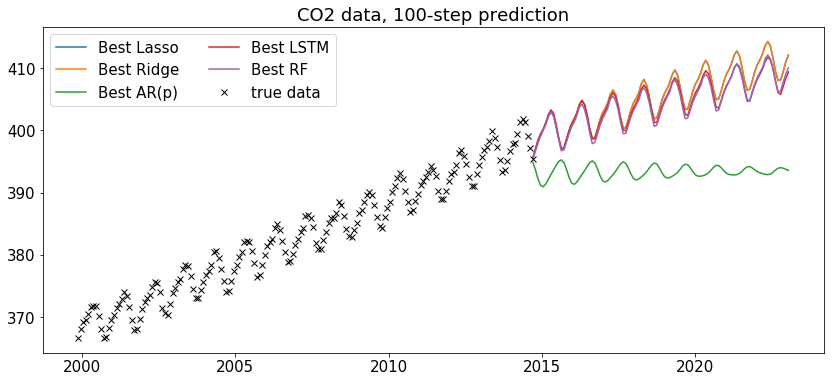

In [220]:
from matplotlib import rcParams
l = len(co2[500:])
rcParams.update({'font.size': 15})
years1= loadmat('co2.mat')['year']


fig = plt.figure(figsize=(14,6))
years = np.hstack((years1[500:,0], np.linspace(years1[-1],years1[-1]+100./12, 100)))
plt.plot(years,np.hstack((np.repeat(np.nan, l), Preds[4,:])),label='Best Lasso')
plt.plot(years,np.hstack((np.repeat(np.nan, l), Preds[3,:])),label='Best Ridge')
plt.plot(years,np.hstack((np.repeat(np.nan, l), Preds[0,:])),label='Best AR(p)')
plt.plot(years, np.hstack((np.repeat(np.nan, l), Preds[2,:])),label='Best LSTM')
plt.plot(years, np.hstack((np.repeat(np.nan, l), Preds[1,:])),label='Best RF')
plt.plot(years1[500:],co2[500:],'kx',label='true data')
plt.legend(ncol=2)
plt.title('CO2 data, 100-step prediction')
#fig.savefig('CO2_1step.pdf',bbox_inches='tight')



# 3) Sunspots 91x12-point forecasts

In [ ]:
n_predict = 200
n_valid = 100
n_testper = 1  

X_in = np.sqrt(np.append(ssp_train,ssp_test[:200]))
theta, sun_arp = predict_optimize_ARp(X_in,n_predict, n_valid,n_testper,ps=range(2,200,1))
rf, sun_rf = optimize_predict_rf(X_in, n_predict,look_back=80)
lstm, params, sun_lstm = predict_optimize_LSTM(X_in,n_predict, n_valid,n_testper, 
                                              windows=range(1,30,2), lstmsizes=range(1,4),
                                                trainepochs=30, testepochs=40)
rdg, sun_rdg = optimize_predict_ridge(X_in, n_predict,look_back=80)
las, sun_las = optimize_predict_lasso(X_in, n_predict,look_back=80)

In [354]:
ssp_train = loadmat('sunspots.mat')['activity'][:1801]
ssp_test = loadmat('sunspots.mat')['activity'][1801:]
ssp_years = loadmat('sunspots.mat')['year']

print ssp_train.shape,ssp_test.shape

(1801, 1) (1098, 1)


In [404]:
n_predict = 2
n_valid = 400
n_testper = 1  
ssp_train = loadmat('sunspots.mat')['activity'][:1801]
ssp_test = loadmat('sunspots.mat')['activity'][1801:]
X_in = np.sqrt(ssp_train[:,0])

theta, sun_arp = predict_optimize_ARp(X_in,n_predict, n_valid,n_testper,ps=range(1,280))
rf, sun_rf = optimize_predict_rf(X_in, n_predict,look_back=200)
lstm, params, sun_lstm = predict_optimize_LSTM(X_in,n_predict, n_valid,n_testper, 
                                             windows=range(1,200,50), lstmsizes=range(1,2),
                                               trainepochs=30, testepochs=40)
rdg, sun_rdg = optimize_predict_ridge(X_in, n_predict,look_back=200)
las, sun_las = optimize_predict_lasso(X_in, n_predict,look_back=200)

In [410]:
############

def create_dataset2(dataset, look_back=3):
    dataX= []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    return np.array(dataX)
# data for lstm
ssp_train = loadmat('sunspots.mat')['activity'][:1801]
ssp_test = loadmat('sunspots.mat')['activity'][1801:]
window = params[0]

ssp_train,ssp_test = np.sqrt(ssp_train),np.sqrt(ssp_test)
xx = ssp_train[-len(theta):].copy().T
scaler = MinMaxScaler(feature_range=(0, 1))
ssp_train_sc = scaler.fit_transform(ssp_train)
x_lstm = ssp_train_sc[-window:].copy().T
x_rf = ssp_train[-200:].copy().T
x_rdg = ssp_train[-200:].copy().T
x_las = ssp_train[-200:].copy().T

n_predict = 12
n_periods = 91
Preds = np.zeros(shape=(5,12,n_periods))
for y in range(Preds.shape[2]):
    for i in range(n_predict):
        Preds[0,i,y] = np.sum(theta[:,0]* (xx[0,:][::-1]))
        Preds[1,i,y] = rf.predict(x_rf)
        pre = lstm.predict(np.reshape(x_lstm, (x_lstm.shape[0], 1, x_lstm.shape[1])))
        Preds[2,i,y] = scaler.inverse_transform(pre)
        Preds[3,i,y] = rdg.predict(x_rdg)
        Preds[4,i,y] = las.predict(x_las)

        xx[0,0:-1] = xx[0,1:].copy()
        x_rf[0,0:-1] = x_rf[0,1:].copy()
        x_rdg[0,0:-1] = x_rdg[0,1:].copy()
        x_las[0,0:-1] = x_las[0,1:].copy()


        x_lstm[0,0:-1] = x_lstm[0,1:].copy()
        x_lstm[0,-1] = pre
        xx[0,-1] = Preds[0,i,y].copy()
        x_rf[0,-1] = Preds[1,i,y].copy()
        x_rdg[0,-1] = Preds[3,i,y].copy()
        x_las[0,-1] = Preds[4,i,y].copy()
    ssp_train = np.append(ssp_train,ssp_test[12*y:12*(y+1)])[:,np.newaxis]
    xx = ssp_train[-len(theta):].copy().T
    scaler = MinMaxScaler(feature_range=(0, 1))
    ssp_train_sc = scaler.fit_transform(ssp_train)
    x_lstm = ssp_train_sc[-window:].copy().T
    x_rf = ssp_train[-200:].copy().T
    x_rdg = ssp_train[-200:].copy().T
    x_las = ssp_train[-200:].copy().T

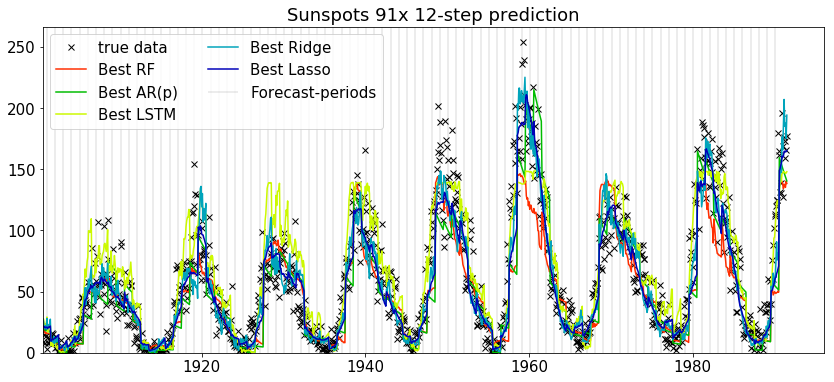

In [413]:
from matplotlib import rcParams
from matplotlib import cm

rcParams.update({'font.size': 15})

Preds2 = np.power(Preds,2)
fig = plt.figure(figsize=(14,6))
plt.plot(ssp_years[-12*Preds.shape[2]:],np.power(ssp_test[:Preds.shape[2]*12],2),'kx',label='true data')
plt.plot(ssp_years[-12*Preds.shape[2]:],Preds2[1,:,:].T.reshape(12*Preds.shape[2],1) ,c= cm.spectral(5./6),label='Best RF')
plt.plot(ssp_years[-12*Preds.shape[2]:],Preds2[0,:,:].T.reshape(12*Preds.shape[2],1),c= cm.spectral(3./6),label='Best AR(p)')

plt.plot(ssp_years[-12*Preds.shape[2]:],Preds2[2,:,:].T.reshape(12*Preds.shape[2],1),c= cm.spectral(4./6),label='Best LSTM')


plt.plot(ssp_years[-12*Preds.shape[2]:],Preds2[3,:,:].T.reshape(12*Preds.shape[2],1),c= cm.spectral(2./6),label='Best Ridge')


plt.plot(ssp_years[-12*Preds.shape[2]:],Preds2[4,:,:].T.reshape(12*Preds.shape[2],1),c= cm.spectral(1./6),label='Best Lasso')
plt.ylim(0)
plt.xlim(ssp_years[-12*Preds.shape[2]][0])
ymin, ymax = plt.gca().get_ylim()
plt.vlines(ssp_years[1801+ np.arange(0,Preds.shape[2]*12,12),0],ymin,ymax,color='grey',linestyle='-',
          alpha=0.2,label='Forecast-periods')
plt.title('Sunspots 91x 12-step prediction')
plt.legend(ncol=2)
fig.savefig('Sunspots_91_12.pdf',bbox_inches='tight')



In [412]:
rmses_ssp = np.array([np.sum((np.power(ssp_test[:Preds.shape[2]*12],2) - Preds2[i,:,:].T.reshape(12*Preds.shape[2],1))**2) for i in range(5)]) 
print rmses_ssp/1000000.

[ 0.80344266  0.90479043  0.73609381  0.56501052  0.555608  ]


In [420]:
x = np.array([ 0.80344266,  0.90479043,  0.73609381,  0.56501052,  0.555608  ])
print np.sqrt(x*1000000)

 [ 896.34963045  951.2047256   857.95909576  751.67181669  745.39117247]


# 4) FX rate data (downsampled)

In [ ]:
X_in = fin[::20][:,0].copy() # take every 20th datapoint wlog
print X_in.shape
n_predict = 50
n_valid = 100
n_testper = 1  
theta, fin_arp = predict_optimize_ARp(X_in,n_predict, n_valid,n_testper,ps=range(1,20,2))
rf, fin_rf = optimize_predict_rf(X_in, n_predict,look_back=50)
lstm, params, fin_lstm = predict_optimize_LSTM(X_in,n_predict, n_valid,n_testper, 
                                             windows=range(3,10), lstmsizes=range(1,2),
                                               trainepochs=30, testepochs=40)
rdg, fin_rdg = optimize_predict_ridge(X_in, n_predict,look_back=50)
las, fin_las = optimize_predict_lasso(X_in, n_predict,look_back=10)
#%%
from matplotlib import rcParams

rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(14,6))
plt.plot(X_in[-n_predict:],'kx')
plt.plot(fin_las,label='Best Lasso')
plt.plot(fin_rdg,label='Best Ridge')
plt.plot(fin_arp,label='Best AR(p)')
plt.plot(fin_lstm,label='Best LSTM')

plt.plot(fin_rf,label='Best RF')


plt.legend()#from matplotlib import rcParams
plt.title('FX rate 50x 1-step prediction')
plt.legend(ncol=2)
fig.savefig('Fin_20_1x50.pdf',bbox_inches='tight')
print [np.sum((X_in[-n_predict:] - x)**2) for x in [fin_las,fin_rdg,fin_arp,fin_lstm,fin_rf]]